# Chapter 7 - Moving Beyond Linearity

- [Lab 7.8.1 Polynomial Regression and Step Functions](#lab-7.8.1)
- [Lab 7.8.2 Splines](#lab-7.8.2)
- [Lab 7.8.3 GAMs](#lab-7.8.3)

### Imports and Configurations

In [1]:
# Standard imports
import warnings

# Use rpy2 for loading R datasets
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import data as rdata
from rpy2.robjects import pandas2ri

# Math and data processing
import numpy as np
import scipy as sp
import pandas as pd

# StatsModels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from patsy import dmatrix

# scikit-learn
from sklearn.preprocessing import PolynomialFeatures

# Visulization
from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('ggplot')

**Load wage data set from R ISLR library.**

In [2]:
# wage dataset is in R ISLR package
islr = importr('ISLR')
wage_rdf = rdata(islr).fetch('Wage')['Wage']
wage = pandas2ri.ri2py(wage_rdf)
display(wage.head(5))

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [3]:
wage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 231655 to 453557
Data columns (total 12 columns):
year          3000 non-null int32
age           3000 non-null int32
sex           3000 non-null object
maritl        3000 non-null object
race          3000 non-null object
education     3000 non-null object
region        3000 non-null object
jobclass      3000 non-null object
health        3000 non-null object
health_ins    3000 non-null object
logwage       3000 non-null float64
wage          3000 non-null float64
dtypes: float64(2), int32(2), object(8)
memory usage: 281.2+ KB


**Utility function definition.**

In [4]:
def ortho_poly_fit(x, degree = 1):
    '''
    Convert data into orthogonal basis for polynomial regression by QR decomposition.
    Ref: http://davmre.github.io/python/2013/12/15/orthogonal_poly
    '''
    n = degree + 1
    x = np.asarray(x).flatten()
    if(degree >= len(np.unique(x))):
            stop("'degree' must be less than number of unique points")
    xbar = np.mean(x)
    x = x - xbar
    X = np.fliplr(np.vander(x, n))
    q,r = np.linalg.qr(X)

    z = np.diag(np.diag(r))
    raw = np.dot(q, z)

    norm2 = np.sum(raw**2, axis=0)
    alpha = (np.sum((raw**2)*np.reshape(x,(-1,1)), axis=0)/norm2 + xbar)[:degree]
    Z = raw / np.sqrt(norm2)
    return Z, norm2, alpha

<a id='lab-7.8.1'></a>

### Lab 7.8.1 Polynomial Regression and Step Functions

**Polynomial regression of degree 4 on orthogonalized X.**

In [5]:
# Polynomial regression of degree 4 on orthogonalized X. Refer to chapter 3 notebook.
X4_ortho = ortho_poly_fit(wage[['age']], degree=4)[0]
X4_ortho[:,0]=1  # Replace constant column with 1s for Intercept estimation.
poly4_ortho = sm.GLS(wage['wage'], X4_ortho).fit()
print(poly4_ortho.summary())

                            GLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            GLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Tue, 21 Mar 2017   Prob (F-statistic):           2.77e-57
Time:                        18:05:48   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        111.7036      0.729    153.283      0.0

**Polynomial regression of degree 4 on raw X without orthogonalization.**

In [6]:
# Polynomial regression of degree 4 on raw X without orthogonalization.
X4 = PolynomialFeatures(degree=4).fit_transform(wage[['age']])
poly4 = sm.GLS(wage['wage'], X4).fit()
print(poly4.summary())

                            GLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            GLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Tue, 21 Mar 2017   Prob (F-statistic):           2.77e-57
Time:                        18:05:49   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -184.1542     60.040     -3.067      0.0

**Predict over a grid of age.**

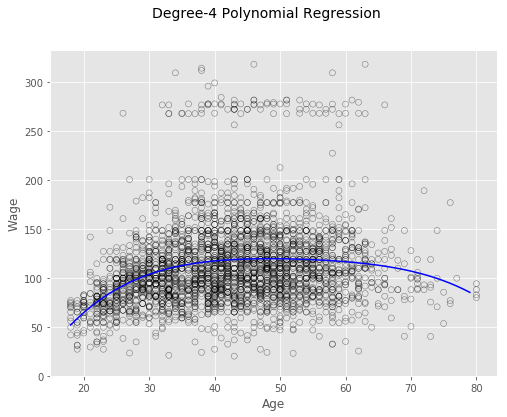

In [7]:
# Generate a sequence of age values spanning the range
age_grid = np.arange(wage.age.min(), wage.age.max()).reshape(-1,1)

# Generate test data
X_test = PolynomialFeatures(4).fit_transform(age_grid)

# Predict the value of the generated ages
y_pred = poly4.predict(X_test)

# Plot
fig, ax = plt.subplots(figsize=(8,6))
fig.suptitle('Degree-4 Polynomial Regression', fontsize=14)

# Scatter plot with polynomial regression line
plt.scatter(wage.age, wage.wage, facecolor='None', edgecolor='k', alpha=0.5)
plt.plot(age_grid, y_pred, color = 'b')
ax.set_ylim(ymin=0)
plt.xlabel('Age')
plt.ylabel('Wage')
plt.show()

**ANOVA on polynomial regression of degree from 1 to 5.**

In [8]:
# Polynomial regression of degree 1,2,3,5
X1 = PolynomialFeatures(degree=1).fit_transform(wage[['age']])
X2 = PolynomialFeatures(degree=2).fit_transform(wage[['age']])
X3 = PolynomialFeatures(degree=3).fit_transform(wage[['age']])
X5 = PolynomialFeatures(degree=5).fit_transform(wage[['age']])
poly1 = sm.GLS(wage['wage'], X1).fit()
poly2 = sm.GLS(wage['wage'], X2).fit()
poly3 = sm.GLS(wage['wage'], X3).fit()
poly5 = sm.GLS(wage['wage'], X5).fit()
# ANOVA, as in chpater 3 notebook
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")  ## Supress warnings
    display(anova_lm(poly1, poly2, poly3, poly4, poly5))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


>The p-value comparing the cubic and degree-4 polynomials, Model 3 and Model 4, is approximately 5% while the degree-5 polynomial Model 5 seems unnecessary because its p-value is 0.37. Hence, either a cubic or a quartic polynomial
appear to provide a reasonable fit to the data, but lower- or higher-order models are not justified.

In [9]:
# Polynomial regression of degree 5 on orthogonalized X. Refer to chapter 3 notebook.
X5_ortho = ortho_poly_fit(wage[['age']], degree=5)[0]
X5_ortho[:,0]=1  # Replace constant column with 1s for Intercept estimation.
poly5_ortho = sm.GLS(wage['wage'], X5_ortho).fit()
print(poly5_ortho.summary())

                            GLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.087
Model:                            GLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     56.71
Date:                Tue, 21 Mar 2017   Prob (F-statistic):           1.67e-56
Time:                        18:05:49   Log-Likelihood:                -15314.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2994   BIC:                         3.068e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        111.7036      0.729    153.278      0.0

>Notice that the p-values are the same, and in fact the square of the t-statistics are equal to the F-statistics from the anova_lm() function.

** Classification: wage > $250,000 per year?**

In [10]:
# Create binary qualitative response
y_clf = (wage.wage > 250).map({False:0, True:1})
# Logistic regression
logreg = sm.GLM(y_clf, X4, family=sm.families.Binomial()).fit()
print(logreg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2995
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -350.61
Date:                Tue, 21 Mar 2017   Deviance:                       701.22
Time:                        18:05:49   Pearson chi2:                 3.70e+03
No. Iterations:                    12                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -109.5530     47.655     -2.299      0.022      -202.956   -16.150
x1             8.9950      4.187      2.148      0.0

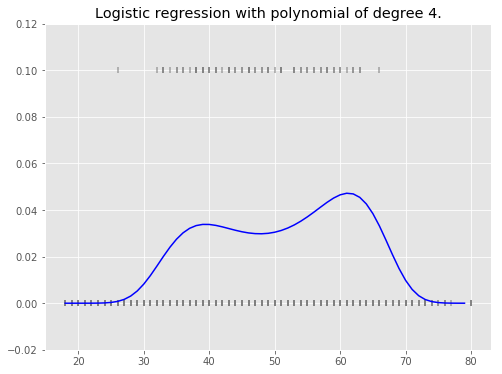

In [11]:
# Predict on age grid
y_pred_clf = logreg.predict(X_test)
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(age_grid, y_pred_clf, color='b')
plt.ylim(-0.02, 0.12)
# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax.scatter(wage.age, y_clf/10, s=30, c='grey', marker='|', alpha=0.7)
plt.title("Logistic regression with polynomial of degree 4.")
plt.show()

**Step functions for piecewise-constant regression**

In [12]:
# Cut predictor data into intervals of a step function
wage_cut, bins = pd.cut(wage.age, 4, retbins=True, right=True)
wage_cut.value_counts(sort=False)

(17.938, 33.5]     750
(33.5, 49]        1399
(49, 64.5]         779
(64.5, 80]          72
Name: age, dtype: int64

In [13]:
# Create dummies for predictor intervals
wage_step_dummies = pd.get_dummies(wage_cut, drop_first=True)  # The first interval is the base and dropped
wage_step_dummies = pd.DataFrame(sm.add_constant(wage_step_dummies.values), columns=['(Intercept)'] + list(wage_step_dummies.columns.values), index=wage_step_dummies.index)
wage_step_dummies.head(25)

,(Intercept),"(33.5, 49]","(49, 64.5]","(64.5, 80]"
231655,1.0,0.0,0.0,0.0
86582,1.0,0.0,0.0,0.0
161300,1.0,1.0,0.0,0.0
155159,1.0,1.0,0.0,0.0
11443,1.0,0.0,1.0,0.0
376662,1.0,0.0,1.0,0.0
450601,1.0,1.0,0.0,0.0
377954,1.0,0.0,0.0,0.0
228963,1.0,1.0,0.0,0.0
81404,1.0,0.0,1.0,0.0


In [14]:
# Piecewise-constant regression as a step function
logreg_step = sm.GLM(wage.wage, wage_step_dummies).fit()
print(logreg_step.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2996
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                   1634.08459238
Method:                          IRLS   Log-Likelihood:                -15353.
Date:                Tue, 21 Mar 2017   Deviance:                   4.8957e+06
Time:                        18:05:49   Pearson chi2:                 4.90e+06
No. Iterations:                     4                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
(Intercept)    94.1584      1.476     63.790      0.000        91.265    97.051
(33.5, 49]     24.0535      1.829     13.148     

<a id='lab-7.8.2'></a>

### Lab 7.8.2 Splines

**Cubic splines**

In [15]:
# Specifying 3 knots
transformed_3knots = dmatrix("bs(wage.age, knots=(25,40,60), degree=3, include_intercept=False)",
                         {"wage.age": wage.age}, return_type='dataframe')

# Build a regular linear model from the splines
spln_3knots = sm.GLM(wage.wage, transformed_3knots).fit()
pred_3knots = spln_3knots.predict(dmatrix("bs(age_grid, knots=(25,40,60), degree=3, include_intercept=False)",
                                          {"age_grid": age_grid}, return_type='dataframe'))
spln_3knots.params

Intercept                                                                 60.493714
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]     3.980500
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]    44.630980
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]    62.838788
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]    55.990830
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]    50.688098
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]    16.606142
dtype: float64

In [16]:
# Specifying 6 degrees of freedom 
transformed_deg6 = dmatrix("bs(wage.age, df=6, include_intercept=False)",
                        {"wage.age": wage.age}, return_type='dataframe')
spln_deg6 = sm.GLM(wage.wage, transformed_deg6).fit()
pred_deg6 = spln_deg6.predict(dmatrix("bs(age_grid, df=6, degree=3, include_intercept=False)",
                                  {"age_grid": age_grid}, return_type='dataframe'))
spln_deg6.params

Intercept                                         56.313841
bs(wage.age, df=6, include_intercept=False)[0]    27.824002
bs(wage.age, df=6, include_intercept=False)[1]    54.062546
bs(wage.age, df=6, include_intercept=False)[2]    65.828391
bs(wage.age, df=6, include_intercept=False)[3]    55.812734
bs(wage.age, df=6, include_intercept=False)[4]    72.131473
bs(wage.age, df=6, include_intercept=False)[5]    14.750876
dtype: float64

**Natural splines**

In [17]:
# Specifying 4 degrees of freedom
transformed_deg4 = dmatrix("cr(wage.age, df=4)", {"wage.age": wage.age}, return_type='dataframe')
spln_deg4 = sm.GLM(wage.wage, transformed_deg4).fit()
pred_deg4 = spln_deg4.predict(dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))
spln_deg4.params

Intercept                79.642095
cr(wage.age, df=4)[0]   -14.667784
cr(wage.age, df=4)[1]    36.811142
cr(wage.age, df=4)[2]    35.934874
cr(wage.age, df=4)[3]    21.563863
dtype: float64

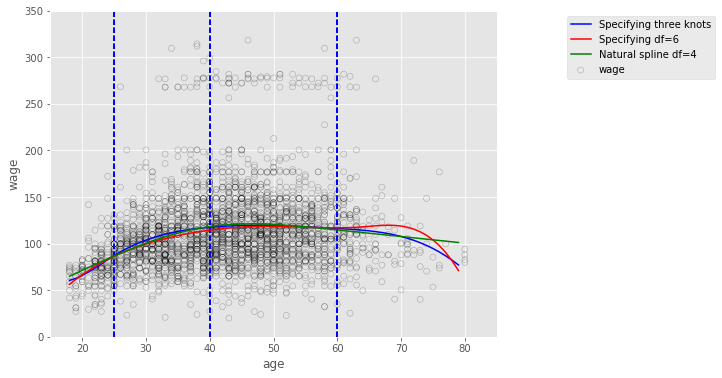

In [18]:
# Plot splines
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(wage.age, wage.wage, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(age_grid, pred_3knots, color='b', label='Specifying three knots')
plt.plot(age_grid, pred_deg6, color='r', label='Specifying df=6')
plt.plot(age_grid, pred_deg4, color='g', label='Natural spline df=4')
[plt.vlines(i , 0, 350, linestyles='dashed', lw=2, colors='b') for i in [25,40,60]]
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage');

<a id='lab-7.8.3'></a>

### Lab 7.8.3 GAMs